# Example Test OtrisymNMF VS DCBM on political blogs


The Zachary's Karate Club network is a commonly used benchmark for evaluating community detection algorithms. The network represents the social interactions among the 34 members of a karate club at an American university. Following an internal conflict, the club split into two distinct factions.


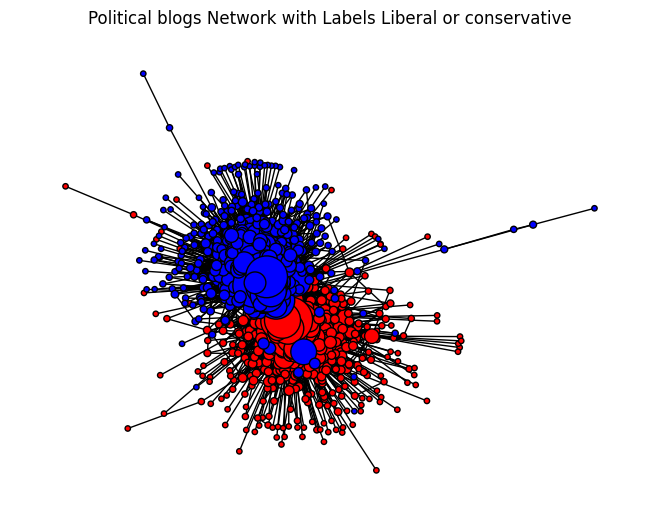

In [91]:
import random

import networkx as nx
import matplotlib.pylab as pl
G=nx.read_gml('Data\polblogs_cleaned.gml',label='id')
wat=sorted(G.nodes)
True_partition = [int(G.nodes[node]['value'] )for node in sorted(G.nodes)]
position = nx.spring_layout(G,seed=14)
# Projeter uniquement sur le plan XY (ignorer la composante Z)
node_sizes = [10+G.degree(node) * 5 for node in G]  # Facteur d'échelle pour bien voir les tailles
nx.draw(G, position, node_color=['r' if i == 0 else 'b' for i in True_partition],node_size=node_sizes, edgecolors='black')
pl.title("Political blogs Network with labels Liberal or Conservative")
pl.show()


Let's use the OtrisymNMF factorization of the adjacency matrix of graph X with r = 2 to detect the 2 communities in the network.
- v is a vector that gives the community index for each node.
- w indicates the importance of a node within its community.
- S describes interactions between the r communities.

Running 100 Trials in Series
Trial 1/100 with SSPA: Error 7.7870e-01 | Best: 7.7870e-01
Trial 2/100 with SVCA: Error 7.7870e-01 | Best: 7.7870e-01
Trial 3/100 with SVCA: Error 7.7870e-01 | Best: 7.7870e-01
Trial 4/100 with SVCA: Error 7.7870e-01 | Best: 7.7870e-01
Trial 5/100 with SVCA: Error 7.7870e-01 | Best: 7.7870e-01
Trial 6/100 with SVCA: Error 7.7870e-01 | Best: 7.7870e-01
Trial 7/100 with SVCA: Error 7.7870e-01 | Best: 7.7870e-01
Trial 8/100 with SVCA: Error 7.7870e-01 | Best: 7.7870e-01
Trial 9/100 with SVCA: Error 7.7870e-01 | Best: 7.7870e-01
Trial 10/100 with SVCA: Error 7.7870e-01 | Best: 7.7870e-01
Trial 11/100 with SVCA: Error 7.7870e-01 | Best: 7.7870e-01
Trial 12/100 with SVCA: Error 7.7870e-01 | Best: 7.7870e-01
Trial 13/100 with SVCA: Error 7.7870e-01 | Best: 7.7870e-01
Trial 14/100 with SVCA: Error 7.7870e-01 | Best: 7.7870e-01
Trial 15/100 with SVCA: Error 7.7870e-01 | Best: 7.7870e-01
Trial 16/100 with SVCA: Error 7.7870e-01 | Best: 7.7870e-01
Trial 17/100 with SV

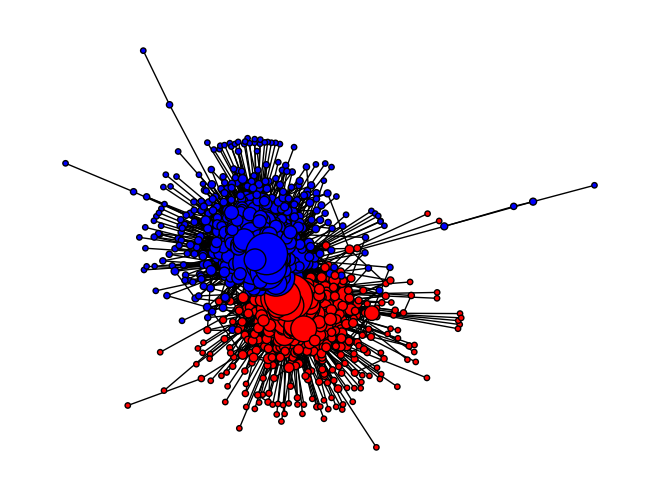

In [113]:
import OtrisymNMF
import numpy as np
np.random.seed(40)
X = nx.adjacency_matrix(G, nodelist=sorted(G.nodes))
w, v, S, error = OtrisymNMF.OtrisymNMF_CD(X, 2,numTrials=100,verbosity=1,delta=1e-7)
position = nx.spring_layout(G,seed=14)
# Projeter uniquement sur le plan XY (ignorer la composante Z)
node_sizes = [10+G.degree(node) * 5 for node in G]  # Facteur d'échelle pour bien voir les tailles
nx.draw(G, position, node_color=['r' if i == 0 else 'b' for i in v],node_size=node_sizes, edgecolors='black')
pl.show()


To compare the partition found by OtrisymNMF with the ground truth partition, we calculate the NMI. We also display the partition obtained by OtrisymNMF. It can be observed that only one node was misclassified—the same node that is misclassified by other community detection methods.

In [114]:
from sklearn.metrics import normalized_mutual_info_score as NMI
print("NMI score:",NMI(True_partition,v))


NMI score: 0.7223895454752098


Now, let's compare it with the degree-corrected model (DCBM) of Karrer and Newman.

Best logP : -333807.2063420393
NMI score: 0.7286769625628147


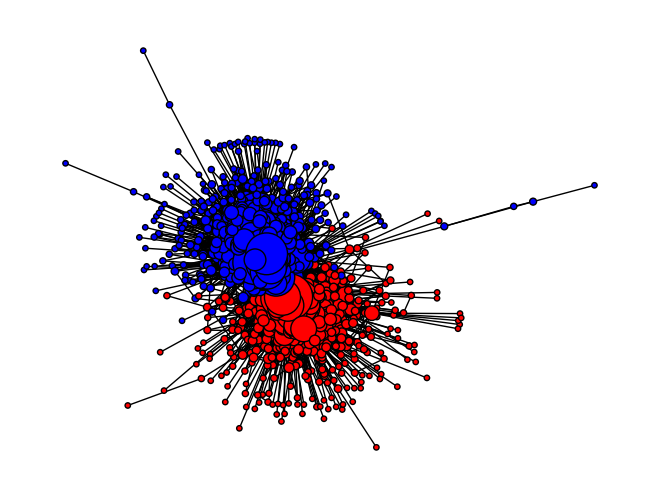

In [106]:
import pysbm
from Utils import DC_BM
import random
random.seed(12)
np.random.seed(40)
DCBM_partition=DC_BM(G,2,pysbm.DegreeCorrectedUnnormalizedLogLikelyhood,pysbm.EMInference, numTrials=1,init_method="SVCA")
print("NMI score:",NMI(True_partition,DCBM_partition))
nx.draw(G, position, node_color=['r' if i == 1 else 'b' for i in DCBM_partition],node_size=node_sizes, edgecolors='black')
pl.show()

We observe that there is one additional misclassified node compared to OtrisymNMF. To verify that this is not due to the inference method, let's calculate the (log) probability of the model for this partition and check that it is indeed higher than that for the ground truth partition and the one found by OtrisymNMF.

In [108]:
np.where(DCBM_partition==v)

(array([   2,   49,   66,   77,  106,  207,  267,  303,  323,  389,  397,
         407,  422,  467,  559,  577,  617,  700,  721,  857, 1054],
       dtype=int64),)

In [116]:

random.seed(12)
np.random.seed(35)
nb_tests=100
trials=1
NMI_moyen={"OtrisymNMF_rdm":[],"OtrisymNMF_SVCA":[],"KL_EM_rdm":[],"KL_EM_SVCA":[]}
success={"OtrisymNMF_rdm":0,"OtrisymNMF_SVCA":0,"KL_EM_rdm":0,"KL_EM_SVCA":0}
for test in range(nb_tests):

    # OtrsisymNMF rdm
    w, v, S, error = OtrisymNMF.OtrisymNMF_CD(X,2,numTrials=trials,verbosity=0,init_method="random")
    NMI_moyen["OtrisymNMF_rdm"].append(NMI(v,True_partition))
    if NMI(v,True_partition)>=0.722389545475209:
        success["OtrisymNMF_rdm"]+=1



    # OtrisymNMF SVCA
    w, v, S, error = OtrisymNMF.OtrisymNMF_CD(X,2,numTrials=trials,verbosity=0,init_method="SVCA")
    NMI_moyen["OtrisymNMF_SVCA"].append(NMI(v,True_partition))
    if NMI(v,True_partition)>= 0.722389545475209 :
        success["OtrisymNMF_SVCA"]+=1

    # KL_EM rdm
    DCBM_partition=DC_BM(G,2,pysbm.DegreeCorrectedUnnormalizedLogLikelyhood,pysbm.EMInference, numTrials=trials,verbosity=0,tri=False,init_method="random")
    NMI_moyen["KL_EM_rdm"].append(NMI(DCBM_partition,True_partition))
    if NMI(DCBM_partition,True_partition)>= 0.72867696256281:
        success["KL_EM_rdm"]+=1

    # KL_EM SVCA
    DCBM_partition=DC_BM(G,2,pysbm.DegreeCorrectedUnnormalizedLogLikelyhood,pysbm.EMInference, numTrials=trials,verbosity=0,tri=False,init_method="SVCA")
    NMI_moyen["KL_EM_SVCA"].append(NMI(DCBM_partition,True_partition))
    if NMI(DCBM_partition,True_partition)>= 0.72867696256281:
        success["KL_EM_SVCA"]+=1

for algo in ["OtrisymNMF_rdm","OtrisymNMF_SVCA","KL_EM_rdm","KL_EM_SVCA"]:
    print(f"NMI moyen pour {algo} : {np.mean(NMI_moyen[algo])} +- {np.std(NMI_moyen[algo])}, and sucesses {success[algo]} on {nb_tests} ")

NMI moyen pour OtrisymNMF_rdm : 0.3340768492342 +- 0.36057103150582237, and sucesses 42 on 100 
NMI moyen pour OtrisymNMF_SVCA : 0.7006117043272796 +- 0.12303601912724262, and sucesses 95 on 100 
NMI moyen pour KL_EM_rdm : 0.601918856926089 +- 0.26316962633344043, and sucesses 32 on 100 
NMI moyen pour KL_EM_SVCA : 0.7066148912190094 +- 0.10096564514926332, and sucesses 51 on 100 
